### C. Semantic Segmentation

So far, we evaluated different segmentation methods based on detecting similarities such as region growing and thresholding. In this section, I want to challenge myself by implementing a Convolutional Neural Network (CNN) algorithm to segment brain tumors using a deep learning method. In this section, I will use TensorFlow, and other required libraries on Python.


The dataset I will be using contains brain MR images together with manual FLAIR abnormality segmentation masks obtained from The Cancer Imaging Archive (TCIA).
Images correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available. (Data source: [The Cancer Imagin Archrive](https://wiki.cancerimagingarchive.net/display/Public/TCGA-LGG#6abaca285cee4c9cac59b0bcff944658))


In what follows, I will start coding, but before we get to the main body of the CNN, we have to import libraries and make the data ready. In each part, I will explain what's happening in detail.

#### Required Libraries:

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from PIL import Image
from tqdm import tqdm
import os
import numpy as np
import random 
from skimage.transform import rotate, rescale
import skimage.io
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import datetime



tf.keras.backend.backend()

'tensorflow'

Before we load and augment the data, let's create the network structure:
The network is a Unet consist of an encoder and a decoder. In the report, I explained everything in detail.

#### Network structure:

In [2]:
def network(img_height = 256, img_width = 256, channels = 3):
    
    """
    The Network is a unet model implemented in the refrence paper.
    The inputs are image height, width, and channels.
    The output is the model.
    """
    
    inputs = Input((img_height, img_width, channels)) #Input image information
    
    #Filters = [32, 64, 128, 256, 512]
    
    conv1 = Conv2D(32, (3, 3), padding='same')(inputs) #3 by 3 convolution with same padding
    conv1 = Activation('relu')(conv1) #relu activation
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1) #3 by 3 convolution with same padding
    conv1 = Activation('relu')(conv1) #relu activation
    Max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #Maxpooling filter 
    
    conv2 = Conv2D(64, (3, 3), padding='same')(Max_pool1) #3 by 3 convolution with same padding
    conv2 = Activation('relu')(conv2) #relu activation
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2) #3 by 3 convolution with same padding
    conv2 = Activation('relu')(conv2) #relu activation
    Max_pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #Maxpooling filter
    
    conv3 = Conv2D(128, (3, 3), padding='same')(Max_pool2) #3 by 3 convolution with same padding
    conv3 = Activation('relu')(conv3) #relu activation
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3) #3 by 3 convolution with same padding
    conv3 = Activation('relu')(conv3) #relu activation
    Max_pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #Maxpooling filter
    
    conv4 = Conv2D(256, (3, 3), padding='same')(Max_pool3) #3 by 3 convolution with same padding
    conv4 = Activation('relu')(conv4) #relu activation
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4) #3 by 3 convolution with same padding
    conv4 = Activation('relu')(conv4) #relu activation
    Max_pool4 = MaxPooling2D(pool_size=(2, 2))(conv4) #Maxpooling filter
    
    conv5 = Conv2D(512, (3, 3), padding='same')(Max_pool4) #3 by 3 convolution with same padding
    conv5 = Activation('relu')(conv5) #relu activation
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5) #3 by 3 convolution with same padding
    conv5 = Activation('relu')(conv5) #relu activation
    
    upconv1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5) #2 by 2 up convolution with (2, 2) strides, same padding
    concat1 = concatenate([upconv1, conv4], axis=3)
    
    conv6 = Conv2D(256, (3, 3), padding='same')(concat1) #3 by 3 convolution with same padding
    conv6 = Activation('relu')(conv6) #relu activation
    conv6 = Conv2D(256, (3, 3), padding='same')(conv6) #3 by 3 convolution with same padding
    conv6 = Activation('relu')(conv6) #relu activation
    
    upconv2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6) #2 by 2 up convolution with (2, 2) strides, same padding
    concat2 = concatenate([upconv2, conv3], axis=3) #Adding the encoder to decoder output
    
    conv7 = Conv2D(128, (3, 3), padding='same')(concat2) #3 by 3 convolution with same padding
    conv7 = Activation('relu')(conv7) #relu activation
    conv7 = Conv2D(128, (3, 3), padding='same')(conv7) #3 by 3 convolution with same padding
    conv7 = Activation('relu')(conv7) #relu activation
    
    upconv3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7) #2 by 2 up convolution with (2, 2) strides, same padding
    concat3 = concatenate([upconv3, conv2], axis=3) #Adding the encoder to decoder output
    
    conv8 = Conv2D(64, (3, 3), padding='same')(concat3) #3 by 3 convolution with same padding
    conv8 = Activation('relu')(conv8) #relu activation
    conv8 = Conv2D(64, (3, 3), padding='same')(conv8) #3 by 3 convolution with same padding
    conv8 = Activation('relu')(conv8) #relu activation
    
    upconv4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8) #2 by 2 up convolution with (2, 2) strides, same padding
    concat4 = concatenate([upconv4, conv1], axis=3) #Adding the encoder to decoder output
    
    conv9 = Conv2D(32, (3, 3), padding='same')(concat4) #3 by 3 convolution with same padding
    conv9 = Activation('relu')(conv9) #relu activation
    conv9 = Conv2D(32, (3, 3), padding='same')(conv9) #3 by 3 convolution with same padding
    conv9 = Activation('relu')(conv9) #relu activation
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9) #1 by 1 convolution with sigmoid activation

    model = Model(inputs=[inputs], outputs=[outputs]) #The output model
    
    return model

#### Load the data:

Now it's time to load data, the challenging part. 
We have images with masks in different folders. Masks have the same name as images plus a "_mask" string.
First, we remove the useless files and save images and masks in 2 different directories.

We have images and masks in 2 different directories temp_image_path, and temp_mask_path.
In this part, we will check that if there are images without masks, and if there are, delete them.

All images have mask, so we can go to next step.
Let's create three directories for train, val, and test data.

In [3]:
# train_dir = "E:\\ADIP Project\\Segmentation Part2\\Images\\train"
train_dir = "/home/ubuntu/data/Images/train"
    
# val_dir = "E:\\ADIP Project\\Segmentation Part2\\Images\\validate"
val_dir = "/home/ubuntu/data/Images/validate"

    
# test_dir = "E:\\ADIP Project\\Segmentation Part2\\Images\\test"
test_dir = "/home/ubuntu/data/Images/test"

Directory  E:\ADIP Project\Segmentation Part2\Images\train  already exists
Directory  E:\ADIP Project\Segmentation Part2\Images\validate  already exists
Directory  E:\ADIP Project\Segmentation Part2\Images\test  already exists


we shuffle images and masks with the same seed value to have them parallel to each other in two directories, then split them into three groups.

In the next three portions, we define some augmentation tasks and load the data ready for training.

In [4]:
def rotate_img(img, img_mask): #rotation task
    angle = np.random.uniform(5.0, 15.0) * np.random.choice([-1.0, 1.0], 1)[0]

    img = rotate(img, angle, resize=False, order=3, preserve_range=True)
    img_mask = rotate(img_mask, angle, resize=False, order=0, preserve_range=True)

    return img, img_mask


def scale_img(img, img_mask, img_height = 256, img_width = 256): #scaling task
    scale = 1.0 + np.random.uniform(0.04, 0.08) * np.random.choice([-1.0, 1.0], 1)[0]

    img = rescale(img, scale, order=3, preserve_range=True)
    img_mask = rescale(img_mask, scale, order=0, preserve_range=True)
    if scale > 1:
        img = center_crop(img, img_height, img_width)
        img_mask = center_crop(img_mask, img_height, img_width)
    else:
        img = zeros_pad(img, img_height)
        img_mask = zeros_pad(img_mask, img_height)

    return img, img_mask


def center_crop(img, cropx, cropy): #cropping
    x = img.shape[1] // 2 - (cropx // 2)
    y = img.shape[0] // 2 - (cropy // 2)
    return img[y : y + cropy, x : x + cropx]


def zeros_pad(img, size): #zero pad
    pad_before = int(round(((size - img.shape[0]) / 2.0)))
    pad_after = size - img.shape[0] - pad_before
    if len(img.shape) > 2:
        return np.pad(img, ((pad_before, pad_after), (pad_before, pad_after), (0, 0)), mode="constant")
    return np.pad(img, (pad_before, pad_after), mode="constant")

In [5]:
def aug(images, masks):

    images_augmentation = []
    masks_augmentation = []
    for i in tqdm(range(len(images))): #if the mask is not a black image, then do the augmentation tasks
        if np.max(masks[i]) < 1:
            continue

        
        image_rotate, mask_rotate = rotate_img(images[i], masks[i]) #rotating
        images_augmentation.append(image_rotate)
        masks_augmentation.append(mask_rotate)
        image_scale, mask_scale = scale_img(images[i], masks[i]) #scaling
        images_augmentation.append(image_scale)
        masks_augmentation.append(mask_scale)
            

        for _ in range(2): # also, if the maks is not black, repeat the image for two times
            images_augmentation.append(images[i])
            masks_augmentation.append(masks[i])

    images_augmentation = np.array(images_augmentation)
    masks_augmentation = np.array(masks_augmentation)
    
#     return images_augmentation, masks_augmentation #add images and augmented images together
    return np.vstack((images, images_augmentation)), np.vstack((masks, masks_augmentation)) #add images and augmented images together

In [6]:
def data(path, img_height = 256, img_width = 256, channels = 3, augmentation = True):
    
    images_list = os.listdir(path)
    
    total_count = int(len(images_list) / 2)
    
    images = np.ndarray((total_count, img_height, img_width, channels), dtype=np.uint8) #(number of images, img_height, img_width, channels)
    masks = np.ndarray((total_count, img_height, img_width), dtype=np.uint8) #(number of images, img_height, img_width)
    names = np.chararray(total_count, itemsize=64)

    i = 0
    for image_name in tqdm(images_list):
        if "mask" in image_name:
            continue

        names = image_name.split(".")[0]
        slice_number = int(names.split("_")[-1])
        patient_id = "_".join(names.split("_")[:-1])

        img = skimage.io.imread(os.path.join(path, image_name), as_gray=False) #read the image
        images[i] = img
        
        image_mask_name = image_name.split(".")[0] + "_mask.tif"
        img_mask = skimage.io.imread(os.path.join(path, image_mask_name), as_gray=True) #read the mask
        img_mask = np.array([img_mask])
        masks[i] = img_mask
        
        i +=1

    images = images.astype("float32")
    mean = np.mean(images)
    std = np.std(images)
    images -= mean
    images /= std
    
    masks = masks[..., np.newaxis]
    masks = masks.astype("float32")
    masks /= 255.
    
    if augmentation == True: 
        images, masks = aug(images, masks)

    return images, masks

#### Compile:

In this section we compile the model and see the summary of parameters in each layer.
I used dice coefficient as the loss function which evaluates the semantic segmentation accuracy. 

In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1.0) #Smooth = 1.0


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [8]:
model = network(img_height = 256, img_width = 256, channels = 3)
optimizer = tf.keras.optimizers.Adam(lr=1e-5) #Adam optimizer with 1e-5 learning rate
model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        activation[0][0]                 
______________________________________________________________________________________________

Total of 7,760,097 parameters which all of them are trainable.

#### Train:

Load the tensorboard to see model and accuracy graphs:

In [9]:
# logs_base_dir = "E:\\ADIP Project\\Segmentation Part2\\logs"
# if not os.path.exists(logs_base_dir):
#         os.mkdir(logs_base_dir)
# %load_ext tensorboard

In [9]:
# weights_path = "E:\\ADIP Project\\Segmentation Part2\\training_weights"
train_path = train_dir
val_path = val_dir 
batch_size = 16
epochs = 32

#Training
def train(train_images, train_masks, val_images, val_masks):
    
#     logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#     tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
    checkpoint = ModelCheckpoint("/home/ubuntu/data/weights/" + "weights{epoch:08d}.h5", save_weights_only=True, period=1)


    model.fit(
        train_images,
        train_masks,
        validation_data=(val_images, val_masks),
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        callbacks=[checkpoint],
    )

In [10]:
train_images, train_masks = data(train_path, img_height = 256, img_width = 256, channels = 3, augmentation = False)
val_images, val_masks = data(val_path, img_height = 256, img_width = 256, channels = 3, augmentation = False)

100%|█████████████████████████████████████████████████████████████████████████████| 2628/2628 [00:12<00:00, 207.11it/s]


In [11]:
train(train_images, train_masks, val_images, val_masks)

Train on 3470 samples, validate on 1314 samples
Epoch 1/32
3470/3470 [==============================] - 182s 52ms/sample - loss: 0.9744 - dice_coef: 0.0256 - val_loss: 0.9665 - val_dice_coef: 0.0332
Epoch 2/32
3470/3470 [==============================] - 170s 49ms/sample - loss: 0.7101 - dice_coef: 0.2899 - val_loss: 0.6802 - val_dice_coef: 0.3176
Epoch 3/32
3470/3470 [==============================] - 171s 49ms/sample - loss: 0.5304 - dice_coef: 0.4697 - val_loss: 0.6006 - val_dice_coef: 0.3981
Epoch 4/32
3470/3470 [==============================] - 171s 49ms/sample - loss: 0.4677 - dice_coef: 0.5323 - val_loss: 0.5328 - val_dice_coef: 0.4664
Epoch 5/32
3470/3470 [==============================] - 171s 49ms/sample - loss: 0.4128 - dice_coef: 0.5871 - val_loss: 0.4895 - val_dice_coef: 0.5095
Epoch 6/32
3470/3470 [==============================] - 172s 49ms/sample - loss: 0.3861 - dice_coef: 0.6135 - val_loss: 0.4898 - val_dice_coef: 0.5093
Epoch 7/32
3470/3470 [========================

KeyboardInterrupt: 

In [23]:
def predict(test_path):
    
    test_images, test_masks = data(test_path, img_height = 256, img_width = 256, channels = 3, augmentation = False)
    model = network(img_height = 256, img_width = 256, channels = 3)    
    model.load_weights("/home/ubuntu/data/weights/.h5")

    # make predictions
    pred_masks = model.predict(test_images, verbose=1)

    

    return test_images, test_masks, pred_masks

test_images, test_masks, pred_masks = predict(test_dir)

100%|██████████████████████████████████████████████████████████████████████████████| 786/786 [00:00<00:00, 1803.81it/s]


393/393 [==============================] - 6s 15ms/sample


Train Accuracy: 90%

Val Accuracy: 85%

#### Predict:


    Original Image            Ground Truth            Predicted Image


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


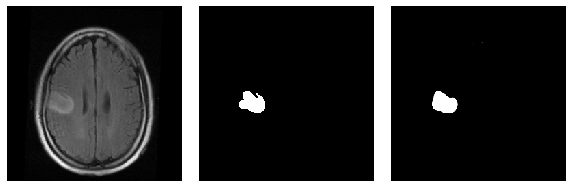

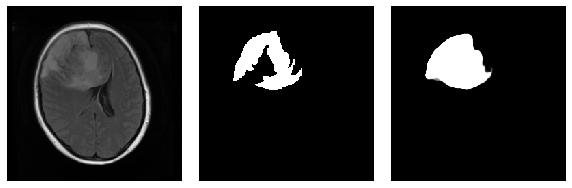

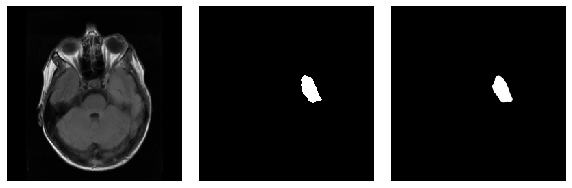

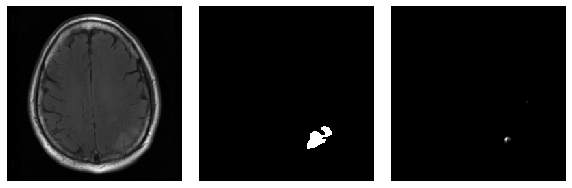

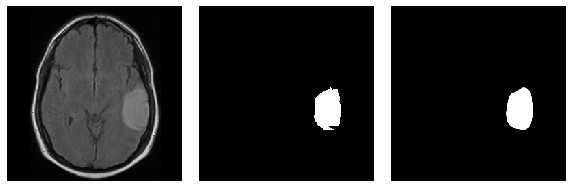

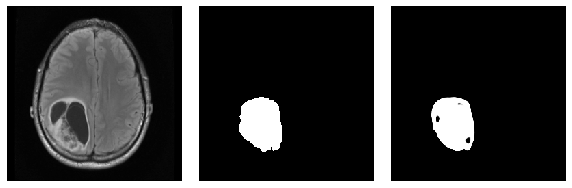

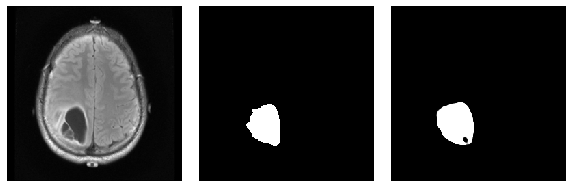

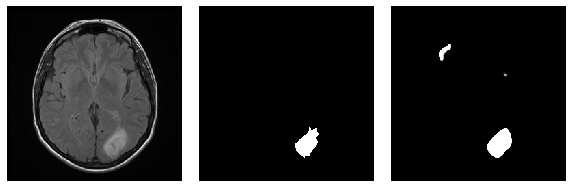

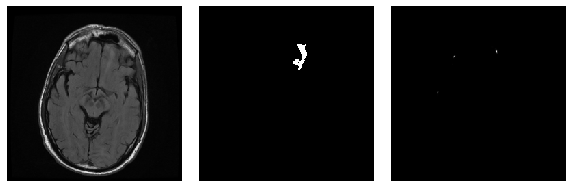

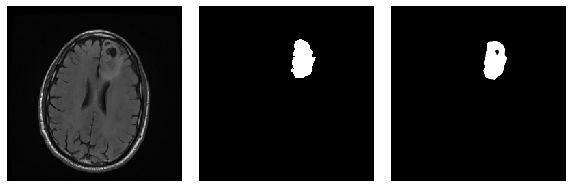

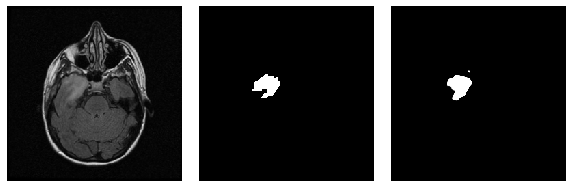

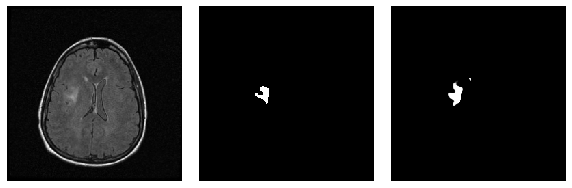

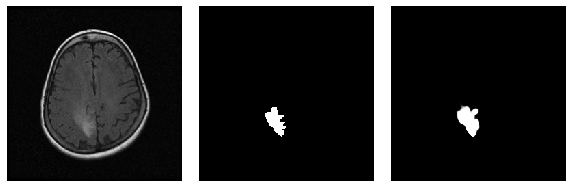

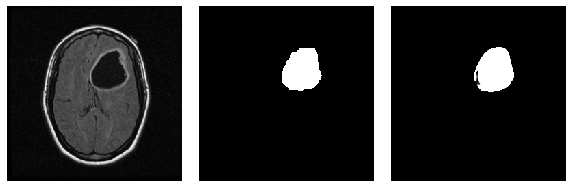

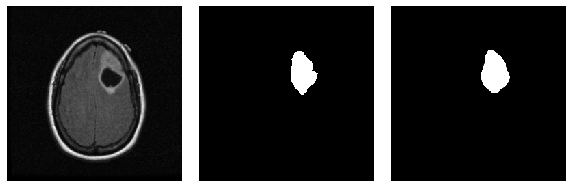

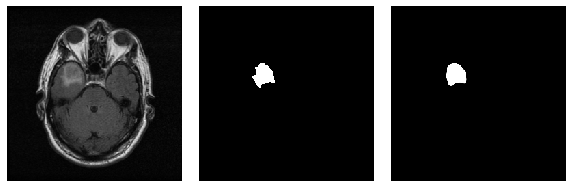

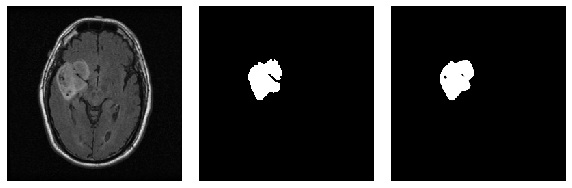

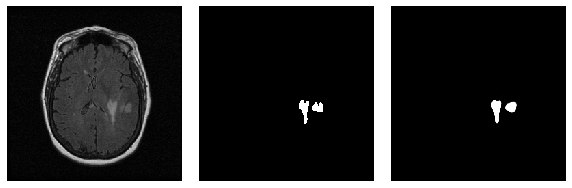

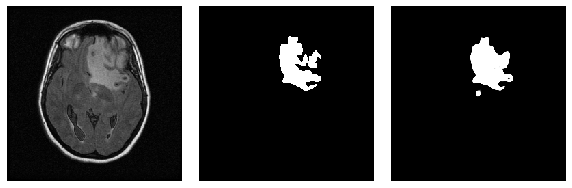

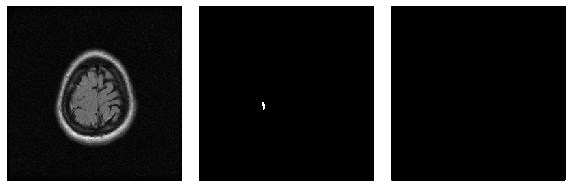

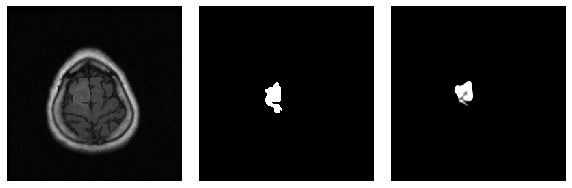

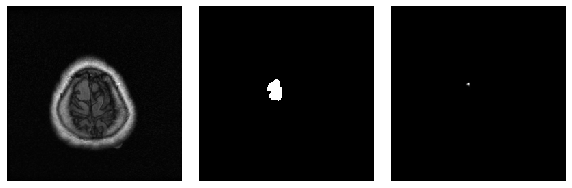

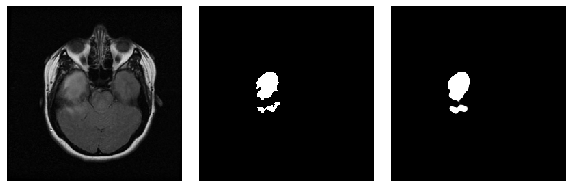

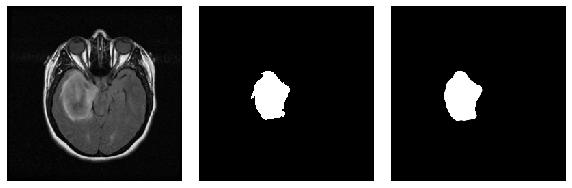

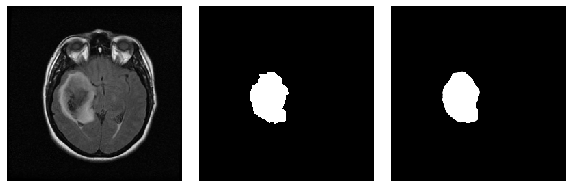

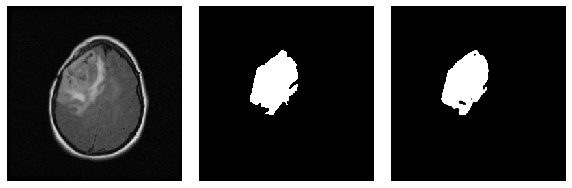

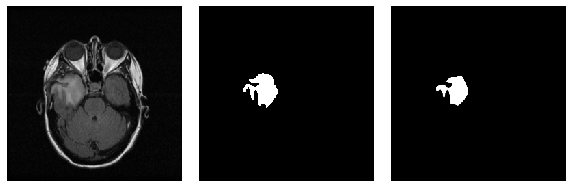

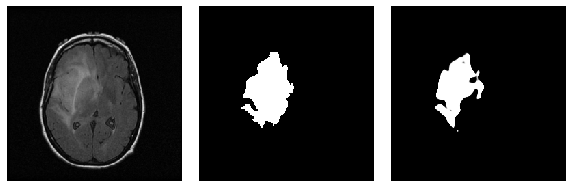

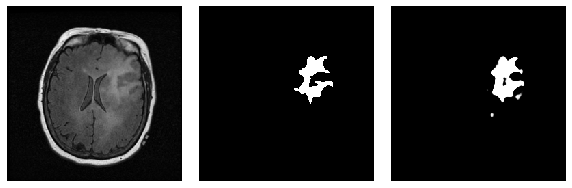

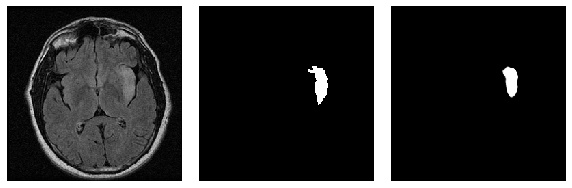

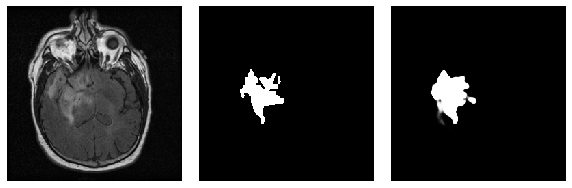

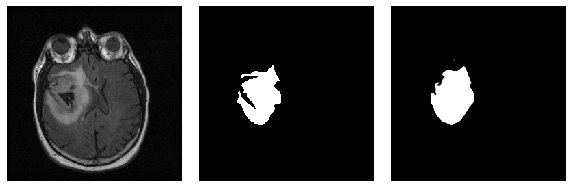

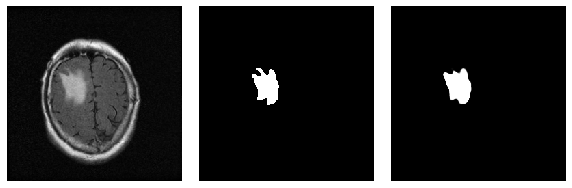

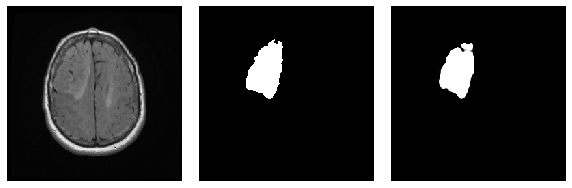

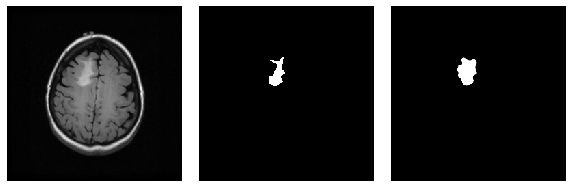

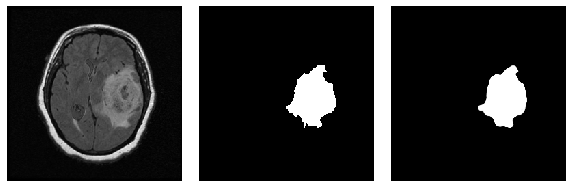

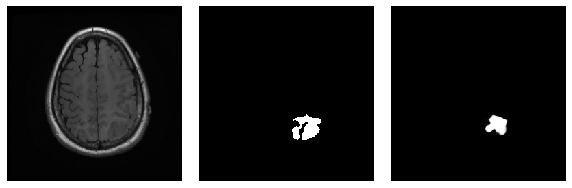

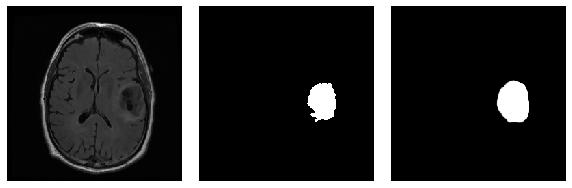

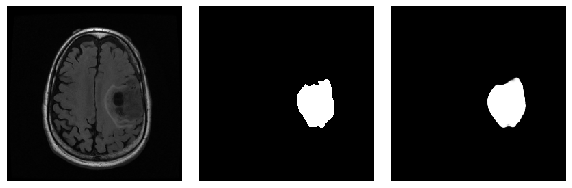

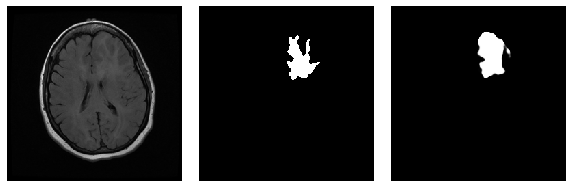

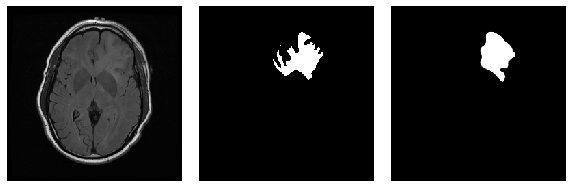

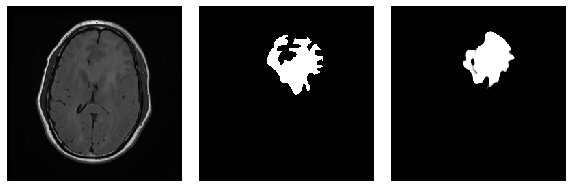

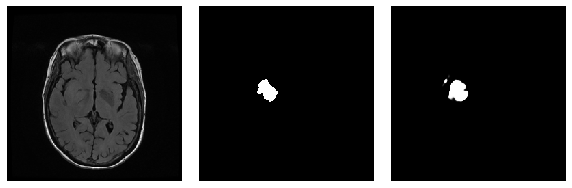

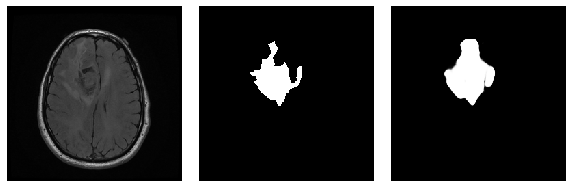

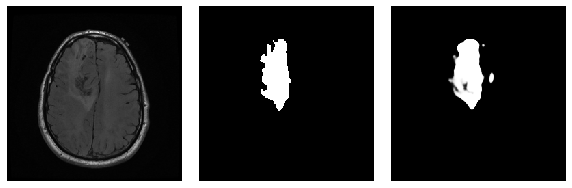

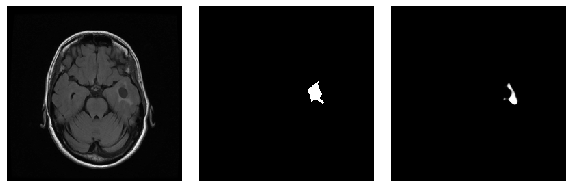

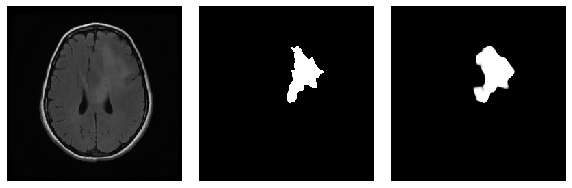

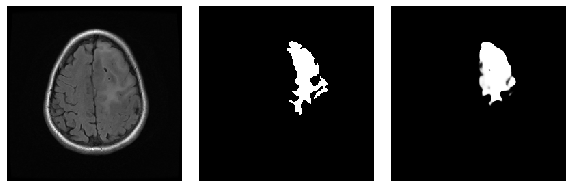

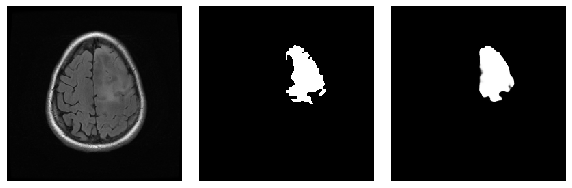

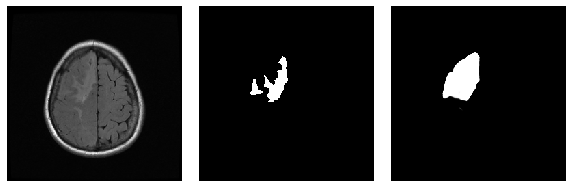

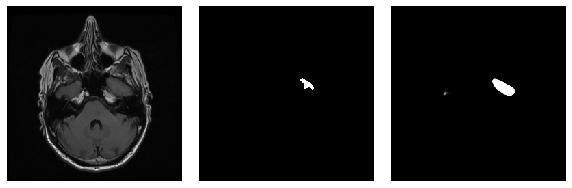

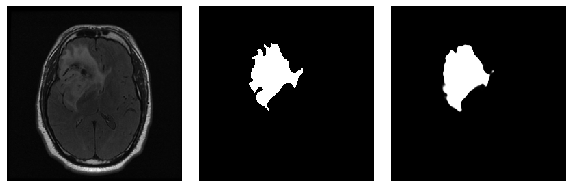

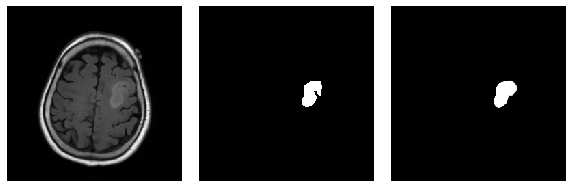

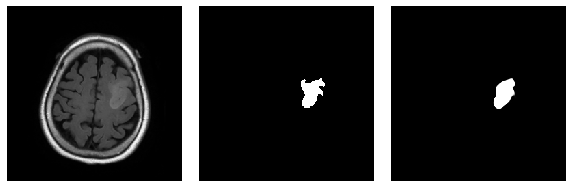

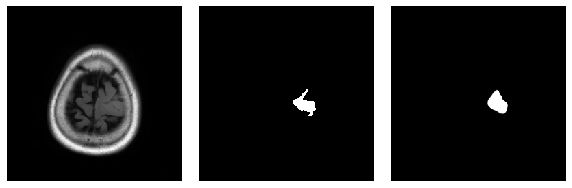

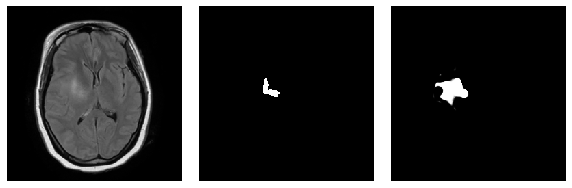

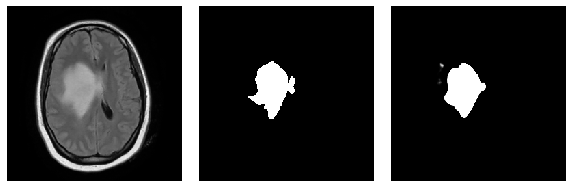

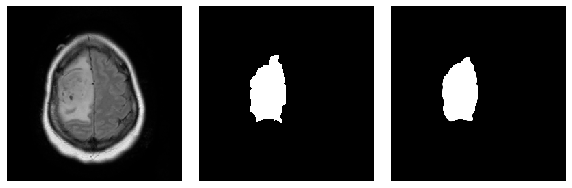

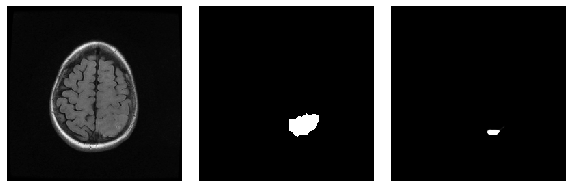

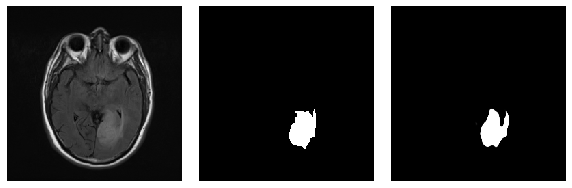

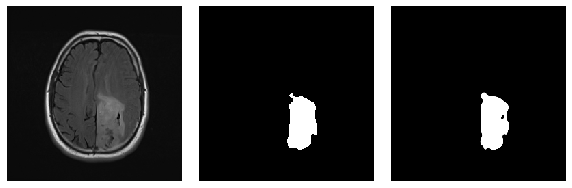

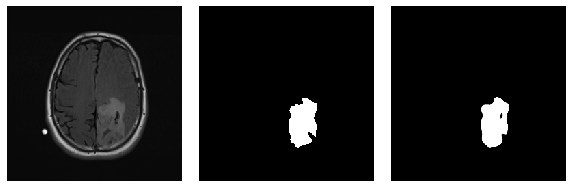

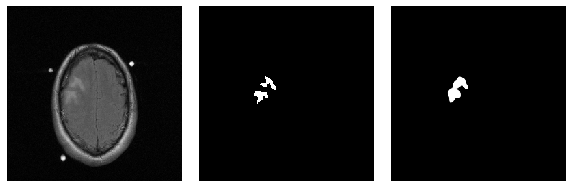

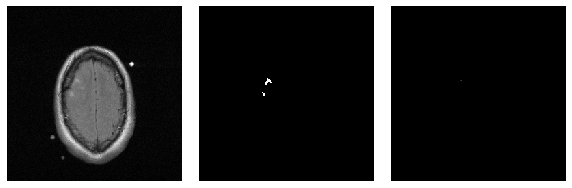

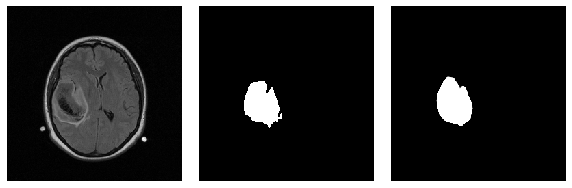

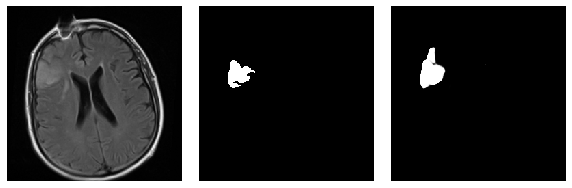

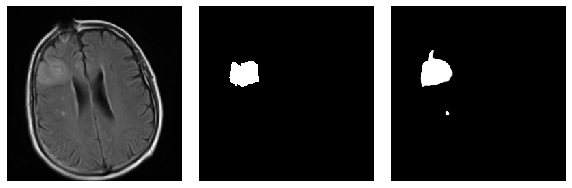

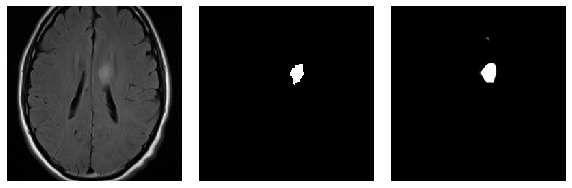

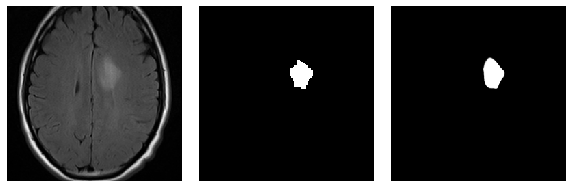

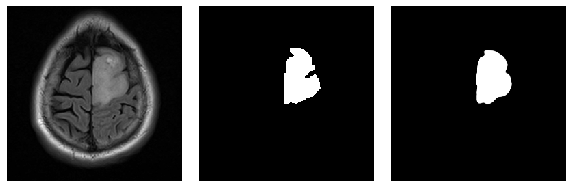

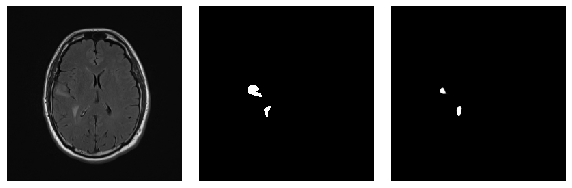

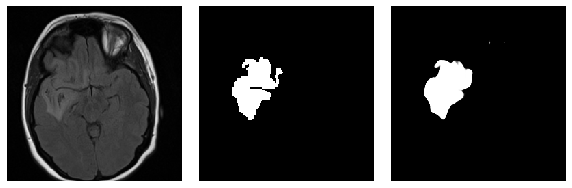

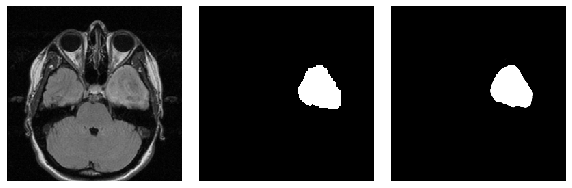

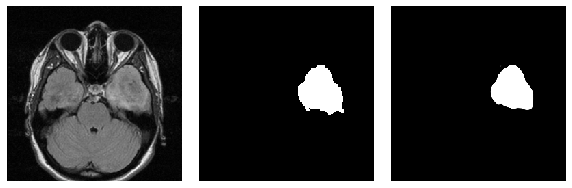

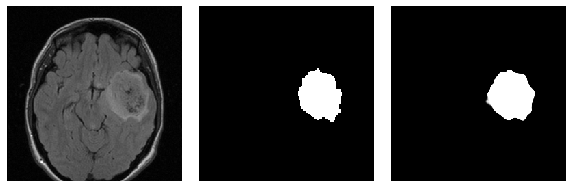

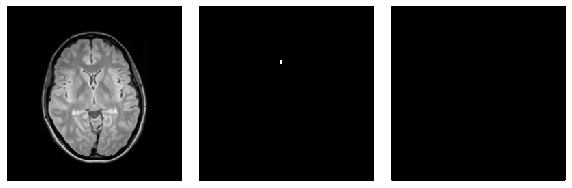

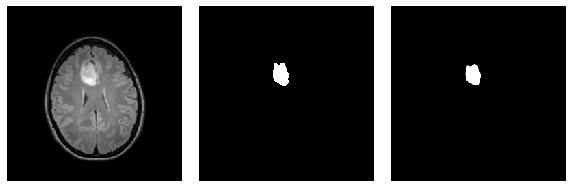

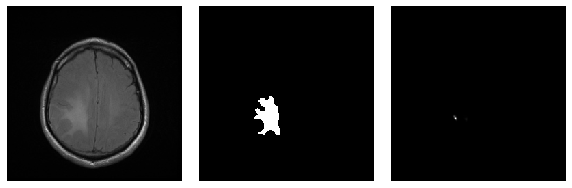

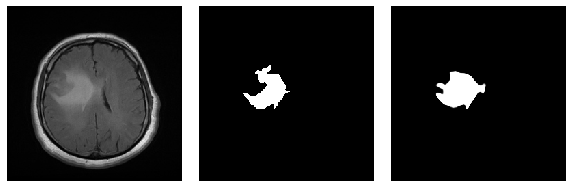

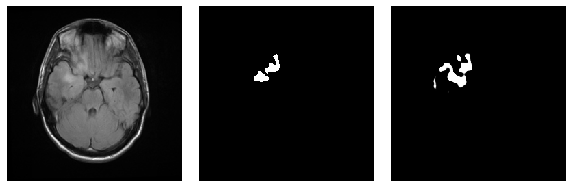

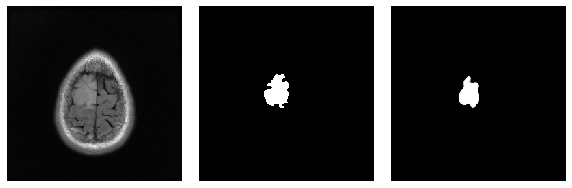

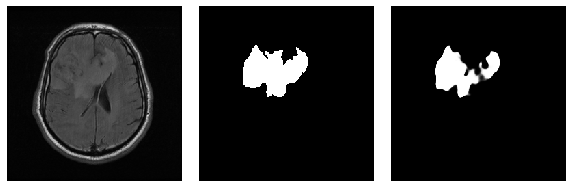

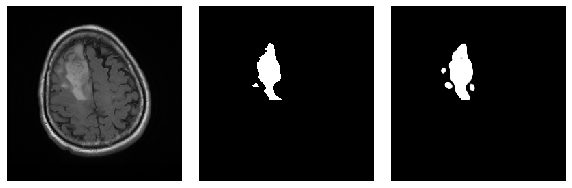

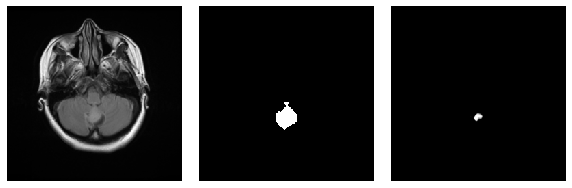

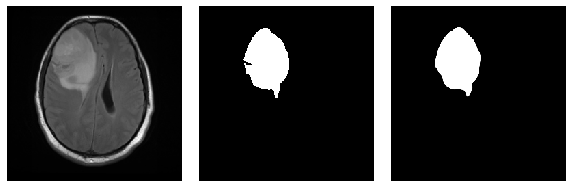

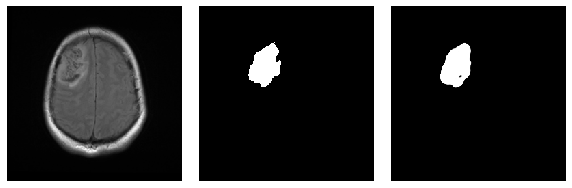

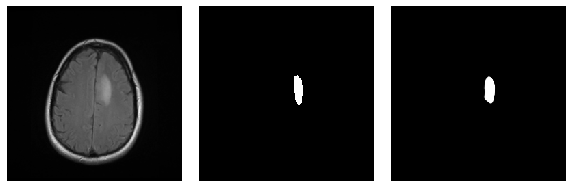

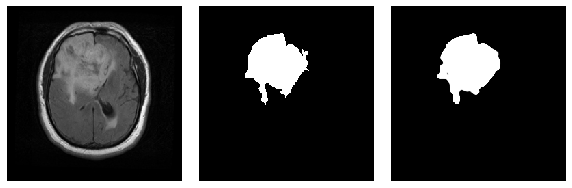

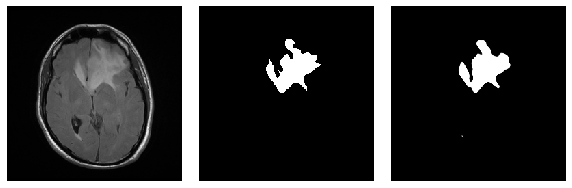

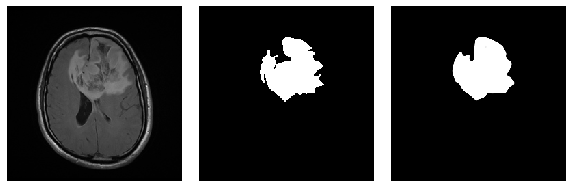

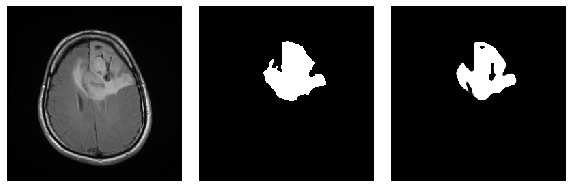

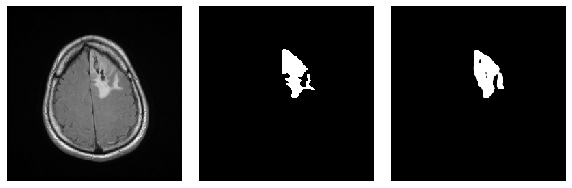

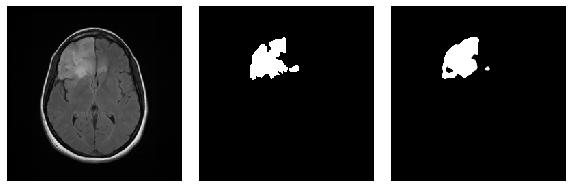

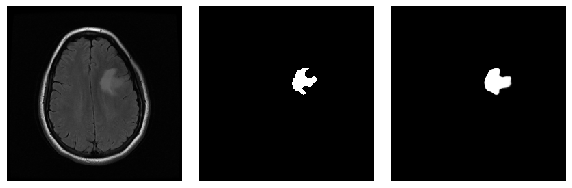

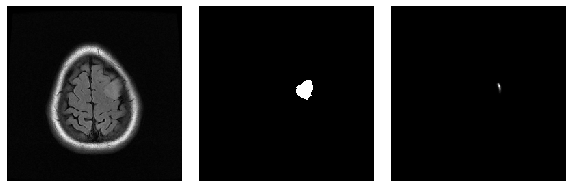

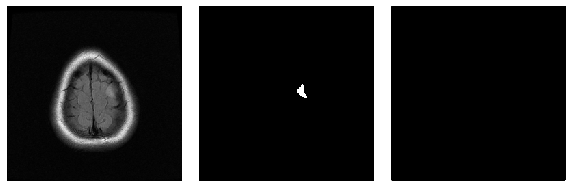

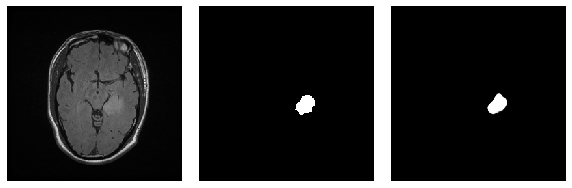

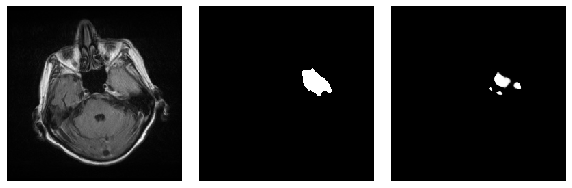

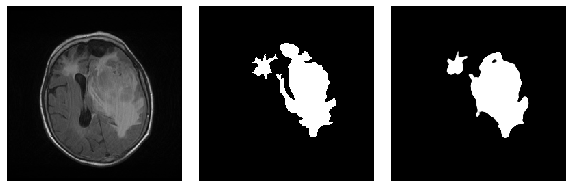

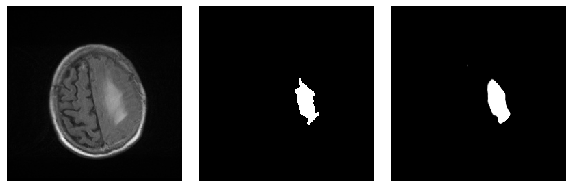

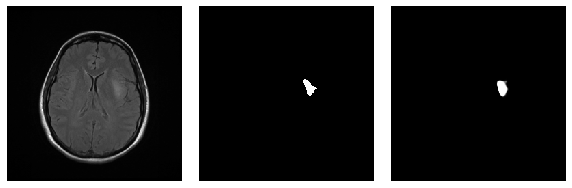

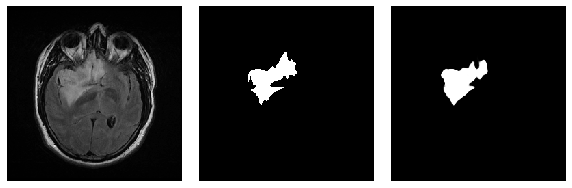

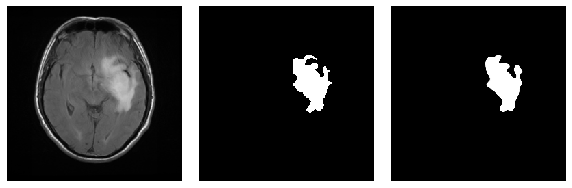

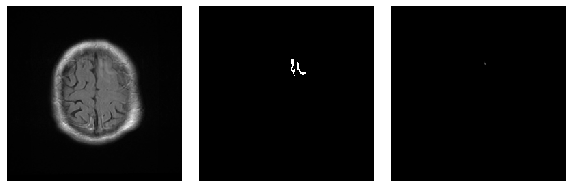

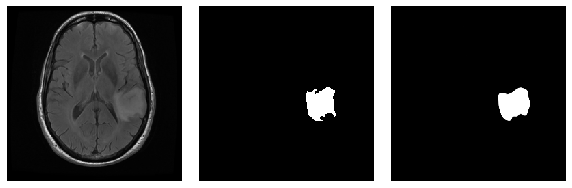

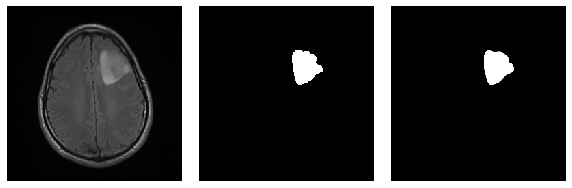

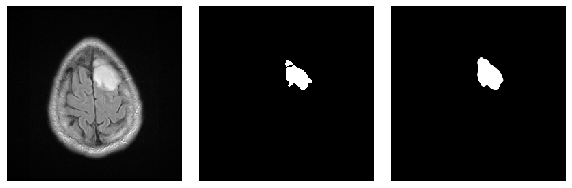

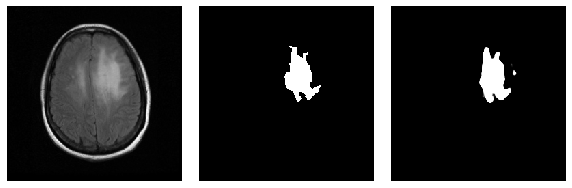

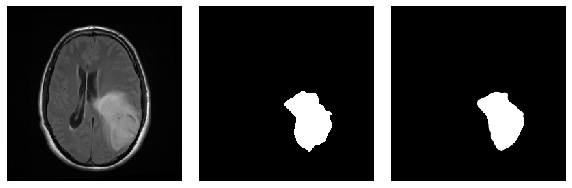

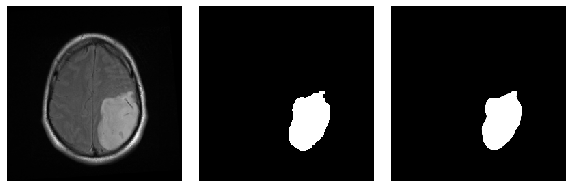

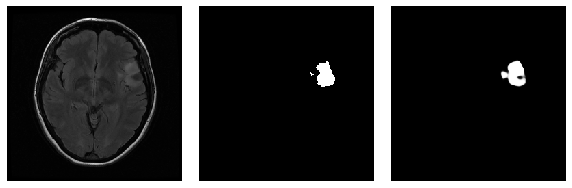

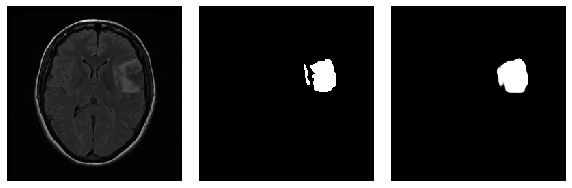

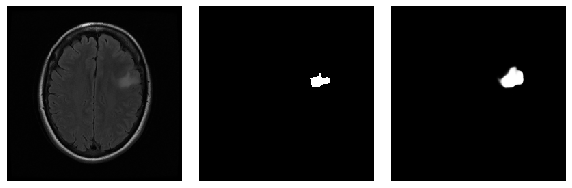

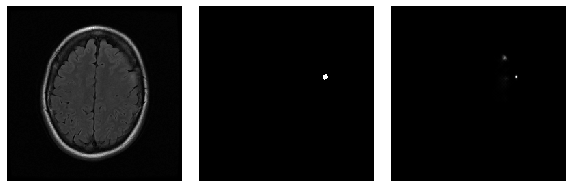

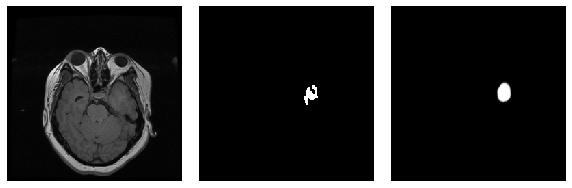

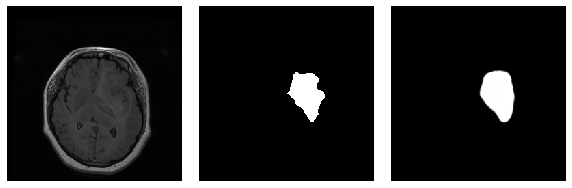

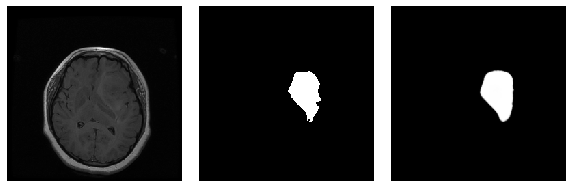

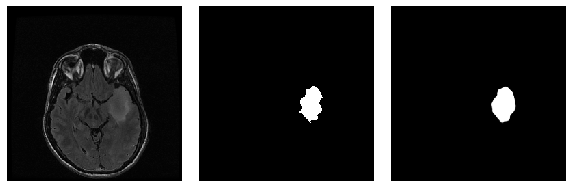

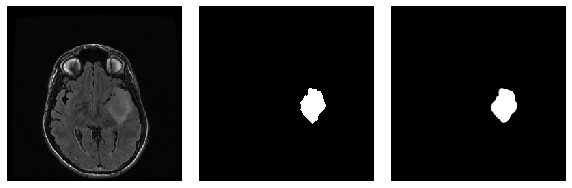

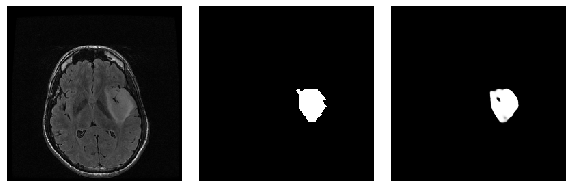

In [117]:
def myshow(image, squeeze, rgb2gray):
    
    if rgb2gray == True:
        img = skimage.color.rgb2gray(image) #Rgb2Gray test images
        
    if squeeze == True: 
        img = np.squeeze(image) #Squeeze Mask images

    return img

print('\033[1m' + "\n    Original Image            Ground Truth            Predicted Image")

for i in range(len(test_images)): #if the mask is not a black image, then do the augmentation tasks
        if np.max(test_masks[i]) < 1:
            continue
        
        #Plotting images
        fig = plt.figure(figsize=(10,10))
        fig.subplots_adjust(hspace=0.1, wspace=0.1)
        ax = fig.add_subplot(1,3,1)
        ax.imshow(myshow(test_images[i], squeeze=False, rgb2gray=True), cmap="gray")
        ax.axis(False)
        ax = fig.add_subplot(1,3,2)
        ax.imshow(myshow(test_masks[i], squeeze=True, rgb2gray=False), cmap="gray")
        ax.axis(False)
        ax = fig.add_subplot(1,3,3)
        ax.imshow(myshow(pred_masks[i], squeeze=True, rgb2gray=False), cmap="gray")
        ax.axis(False)
